In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
import pymc3 as pm

Couldn't import dot_parser, loading of dot files will not be possible.


In [ ]:
df.head()

In [2]:
df = pd.read_csv('../../../globalterrorismdb_0616dist.csv')

/Users/avinashtamby/anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4,61,62,66,116,117,123) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df[(df.country_txt == 'United States') & (df.attacktype1_txt == 'Bombing/Explosion') &
   (~df.addnotes.str.contains('This attack was one of four related incidents', na=False))].iyear.value_counts().values#.plot(kind='hist', bins=46, title='US Attacks')

In [ ]:
df[(df.country_txt == 'United States') &
                  (~df.addnotes.str.contains('This attack was one of four related incidents', na=False)) &
                  (df.iyear > 1984) & (df.iyear < 2002)].iyear.value_counts().plot(kind='hist', bins=46)

In [3]:
attacks85to01 = df[(df.country_txt == 'United States') & (df.attacktype1_txt == 'Bombing/Explosion') &
                   (~df.addnotes.str.contains('This attack was one of four related incidents', na=False)) & 
                   (df.iyear > 1984) & (df.iyear < 2002)].iyear.value_counts().values

attacks02to15 = df[(df.country_txt == 'United States') & (df.attacktype1_txt == 'Bombing/Explosion') &
                   (~df.addnotes.str.contains('This attack was one of four related incidents', na=False)) & 
                   (df.iyear > 2001)].iyear.value_counts().values

mean_prior_mean = df[(df.country_txt == 'United States') & (df.attacktype1_txt == 'Bombing/Explosion') &
                   (~df.addnotes.str.contains('This attack was one of four related incidents', na=False)) & 
                   (df.iyear < 1985)].iyear.value_counts().mean()

mean_prior_std = df[(df.country_txt == 'United States') & (df.attacktype1_txt == 'Bombing/Explosion') &
                   (~df.addnotes.str.contains('This attack was one of four related incidents', na=False)) & 
                   (df.iyear < 1985)].iyear.value_counts().std(ddof=1)

In [10]:
mean_prior_mean

72.73333333333333

In [12]:
mean_prior_std

67.6835775256204

In [4]:
with pm.Model() as model:

    group85to01_mean = pm.Normal('attacks_85_01_mean', mean_prior_mean, sd=mean_prior_std)
    group02to15_mean = pm.Normal('attacks_02_15_mean', mean_prior_mean, sd=mean_prior_std)
    
std_prior_lower = 0.01
std_prior_upper = 100.0
    
with model:
    
    group85to01_std = pm.Uniform('attacks_85_01_std', lower=std_prior_lower, upper=std_prior_upper)
    group02to15_std = pm.Uniform('attacks_02_15_std', lower=std_prior_lower, upper=std_prior_upper)

In [5]:
with model:

    group85to01 = pm.Normal('attacks_85_01', mu=group85to01_mean, sd=group85to01_std, observed=attacks85to01)
    group02to15 = pm.Normal('attacks_02_15', mu=group02to15_mean, sd=group02to15_std, observed=attacks02to15)

In [6]:
with model:

    diff_of_means = pm.Deterministic('difference of means', group85to01_mean - group02to15_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group85to01_std - group02to15_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((group85to01_std**2 + group02to15_std**2) / 2))

In [7]:
with model:
    trace = pm.sample(25000, njobs=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -137.98: 100%|██████████| 200000/200000 [00:46<00:00, 4256.98it/s]
Finished [100%]: Average ELBO = -130.94
100%|██████████| 25000/25000 [01:55<00:00, 216.71it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x122c52ad0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1230ecb90>], dtype=object)

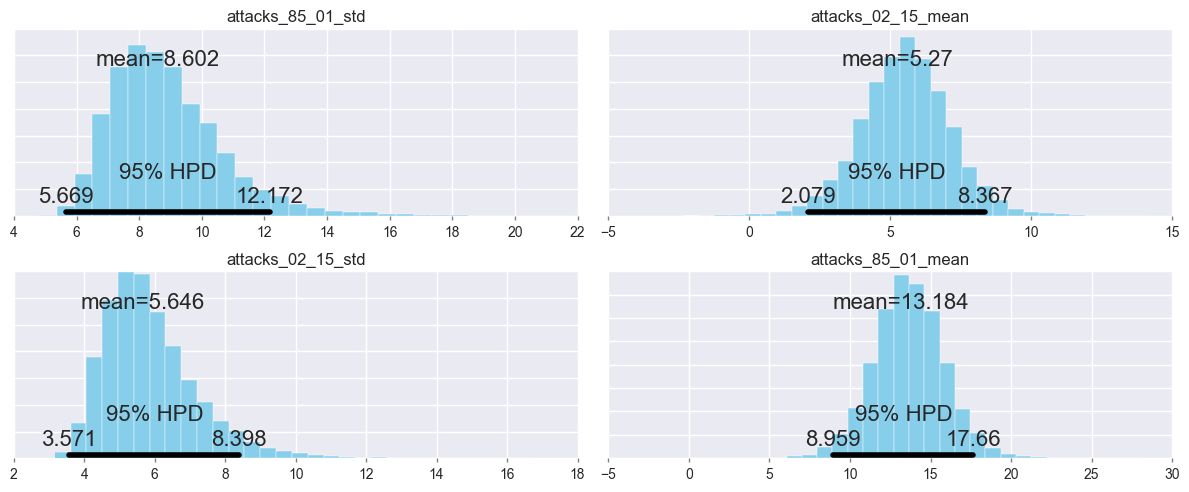

In [8]:
pm.plot_posterior(trace[3000:],
                  varnames=['attacks_85_01_mean', 'attacks_02_15_mean', 'attacks_85_01_std', 'attacks_02_15_std'],
                  color='#87ceeb')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1234dd790>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x122bbcb10>], dtype=object)

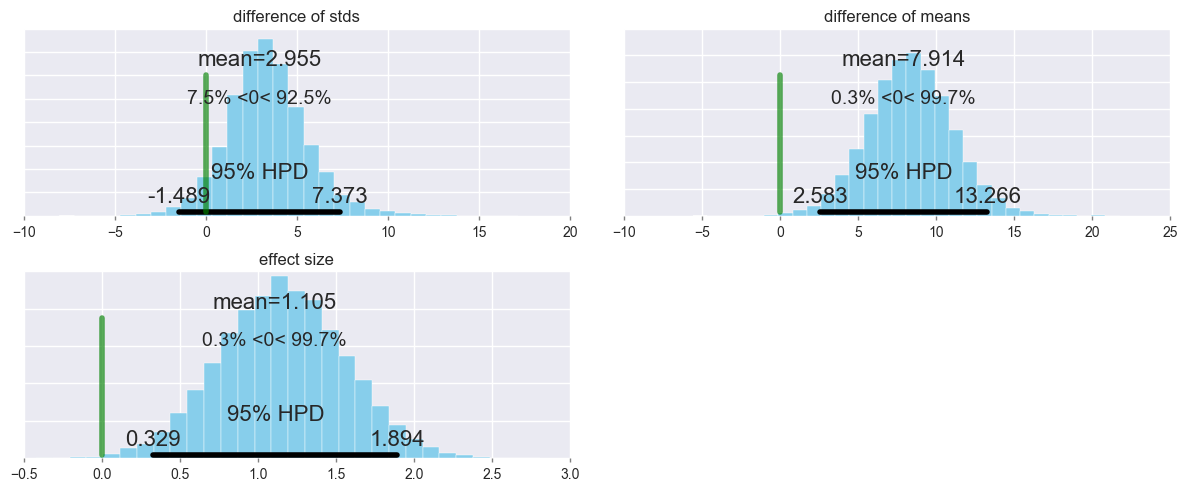

In [9]:
pm.plot_posterior(trace[3000:],
                  varnames=['difference of means', 'difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb')